<a href="https://colab.research.google.com/github/Akshat-afk/Child-Development-Myth-vs-Fact/blob/main/Child_Development_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions

import pandas as pd
import contractions
import string
import re
import time
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Load data
data = pd.read_csv("/content/Myths_and_Facts_Data_on_Child_Development.csv")

print("Original labels:", data['Label'].unique())

data['Label'] = data['Label'].str.strip().str.title()

data = data[data['Label'] != "Hardly Facts Or Myths"]

fact_variants = ['Strong Facts', 'Moderate Facts', 'Weak Facts']
myth_variants = ['Weak Myths', 'Moderate Myths', 'Strong Myths']

data['Label'] = data['Label'].replace({label: "Fact" for label in fact_variants})
data['Label'] = data['Label'].replace({label: "Myth" for label in myth_variants})

label_map = {"Myth": 0, "Fact": 1}
data['Label'] = data['Label'].map(label_map)

print("\nClass distribution:")
print(data['Label'].value_counts())

print("\nPreview of cleaned data:")
print(data.head())
print("\nUnique final labels:", data['Label'].unique())


Original labels: ['Strong facts' 'Moderate facts' 'Weak facts' 'Hardly facts or myths'
 'Weak myths' 'Moderate myths' 'Strong myths']

Class distribution:
Label
1    954
0    437
Name: count, dtype: int64

Preview of cleaned data:
   Label                                         Statements
0      1  One of the biggest threats to a developing fet...
1      1  Maternal stress can affect fetal development, ...
2      1  Stress hormones released by the mother can als...
3      1  Did you know that unborn babies yawn, exercise...
4      1  Your baby can breathe under water while in Ute...

Unique final labels: [1 0]


# **Changes from original**
1.   used uni to **trigram**
2.   more features selected (k = **9000**)
3.   used **mututal_info** instead of chi2
4.   Class imbalance handled (**Stratified** + metrics)

In [ ]:
# Download stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df = data

#data preprocessing
def clean_text(text):
    text = contractions.fix(text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)


df['cleaned_text'] = df['Statements'].apply(clean_text)

# Feature extraction: BoW(uni to tri)(binary)
vectorizer = CountVectorizer(ngram_range=(1,3), binary=True)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['Label']

# Feature selection using Mutual information classification
selector = SelectKBest(score_func=mutual_info_classif, k=9000)
X_selected = selector.fit_transform(X, y)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Model training with GridSearch for smoothing (epsilon / alpha)
parameters = {'alpha': [0.1, 1]}
nb = MultinomialNB()
clf = GridSearchCV(nb,parameters, cv=5)
clf.fit(X_train, y_train)
best_model = clf.best_estimator_

# Evaluation
start = time.time()
y_pred = best_model.predict(X_test)
end = time.time()

print("Best alpha (ε):", clf.best_params_['alpha'])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Myth', 'Fact']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Testing time per statement: {(end - start) / len(y_test) * 1e6:.4f} µs")

# 10-fold cross-validation
cv_scores = cross_val_score(best_model, X_selected, y, cv=10)
print("10-fold CV Accuracy: %.4f" % cv_scores.mean())
print("95%% CI: (%.4f, %.4f)" % (cv_scores.mean() - 2 * cv_scores.std(), cv_scores.mean() + 2 * cv_scores.std()))


Best alpha (ε): 0.1
Accuracy: 0.9605734767025089
Classification Report:
               precision    recall  f1-score   support

        Myth       1.00      0.88      0.93        88
        Fact       0.95      1.00      0.97       191

    accuracy                           0.96       279
   macro avg       0.97      0.94      0.95       279
weighted avg       0.96      0.96      0.96       279

Confusion Matrix:
 [[ 77  11]
 [  0 191]]
Testing time per statement: 2.1586 µs
10-fold CV Accuracy: 0.9741
95% CI: (0.9538, 0.9945)


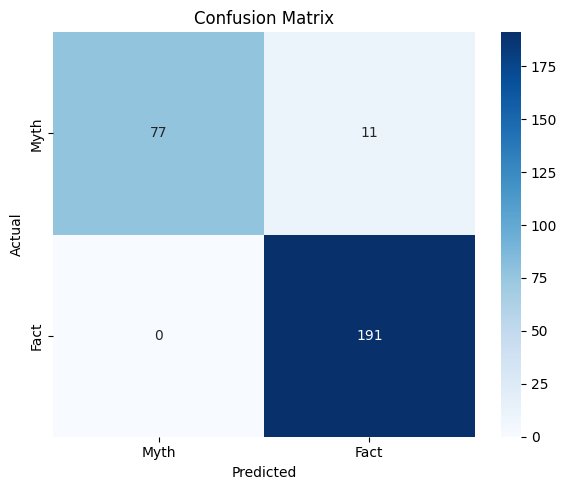

<ipython-input-5-6df2b804f541>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette='viridis')


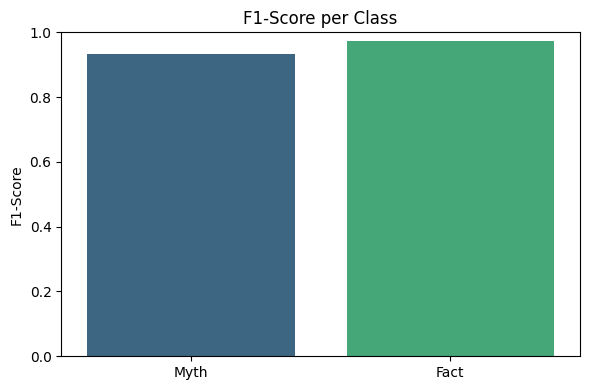

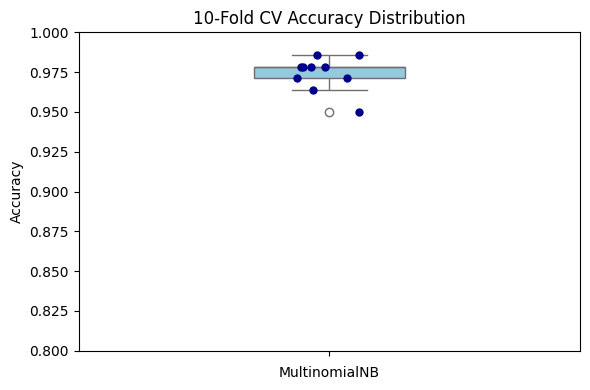

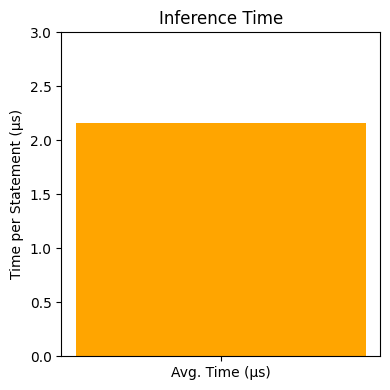

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Myth', 'Fact'], yticklabels=['Myth', 'Fact'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === Classification Report - F1 Scores Bar Plot ===
report_dict = classification_report(y_test, y_pred, target_names=['Myth', 'Fact'], output_dict=True)
labels = ['Myth', 'Fact']
f1_scores = [report_dict[label]['f1-score'] for label in labels]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=f1_scores, palette='viridis')
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.title("F1-Score per Class")
plt.tight_layout()
plt.show()

# === 10-Fold CV Accuracy Distribution ===
plt.figure(figsize=(6, 4))
sns.boxplot(data=cv_scores, color='skyblue', width=0.3)
sns.stripplot(data=cv_scores, color='darkblue', jitter=True, size=6)
plt.title('10-Fold CV Accuracy Distribution')
plt.ylabel('Accuracy')
plt.xlabel('MultinomialNB')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

# === Inference Time per Statement ===
time_per_statement = (end - start) / len(y_test) * 1e6  # µs
plt.figure(figsize=(4, 4))
plt.bar(['Avg. Time (µs)'], [time_per_statement], color='orange')
plt.ylabel("Time per Statement (µs)")
plt.title("Inference Time")
plt.ylim(0, max(3, time_per_statement + 0.5))
plt.tight_layout()
plt.show()
